# Basic Train/Test Experiment on the WESAD data set

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import importlib, sys, os
sys.path.insert(0, os.path.abspath('..'))
if(importlib.util.find_spec("mFlow") is None):
    !git clone https://github.com/mlds-lab/mFlow.git
    !pip install mFlow
else:
    print("mFlow module found")

mFlow module found


## Import library functions

In [5]:
#Import mFlow Functions
from mFlow.Blocks.data_loader_wesad import wesad_data_loader
from mFlow.Blocks.filter import ColumnSelectFilter
from mFlow.Blocks.normalizer import Normalizer
from mFlow.Blocks.experimental_protocol import ExpTrainTest, addTarget, __ExpTrainTest
from mFlow.Blocks.ccwrapper import ccwrapper, cc_to_pandas
from mFlow.Blocks.results_analysis import ResultsConcat, ResultsCVSummarize, DataYieldReport,__DataYieldReport
from mFlow.Workflow.workflow import workflow

#Import cc3 functions
from cerebralcortex.kernel import Kernel
from cerebralcortex.algorithms.ecg.autosense_data_quality import ecg_autosense_data_quality
from cerebralcortex.algorithms.ecg.autosense_rr_interval import get_rr_interval
from cerebralcortex.algorithms.ecg.hrv_features import get_hrv_features

#Import SKLearn Functions
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn import tree
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV


## Define and execute the workflow

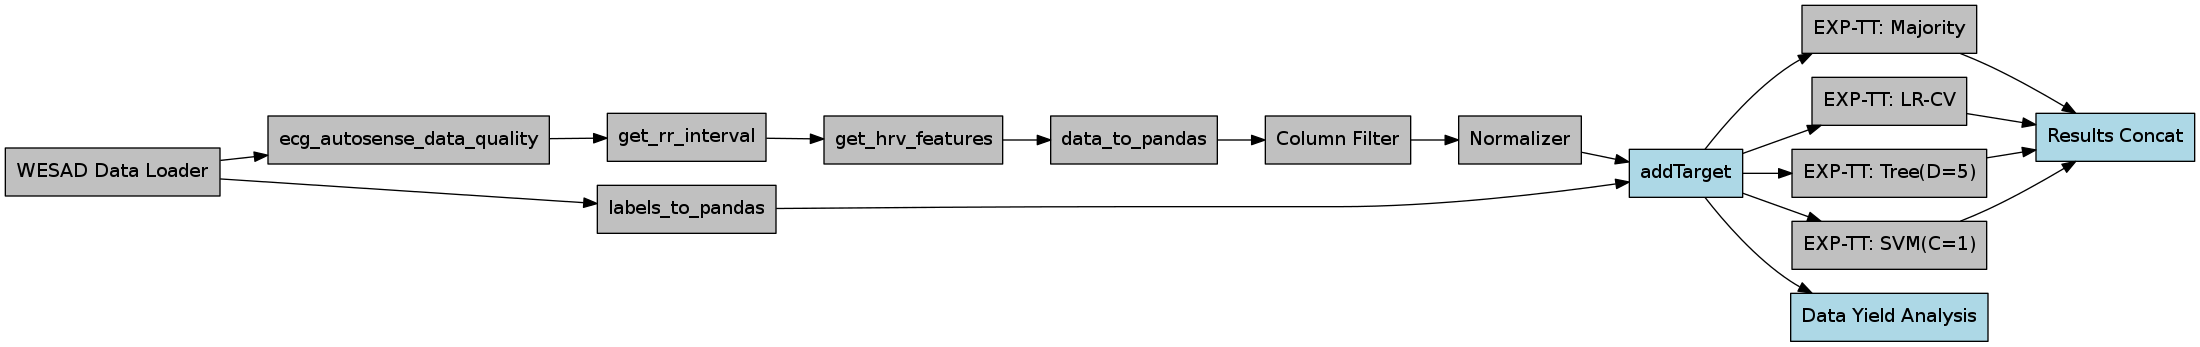

In [14]:
#Define data set properties
Fs         = 700
sensor     = "respiban"
features   = ["var", "iqr", "vlf", "lf", "hf", "lfhf", "mean", "median", "80th", "20th", "heartrate"]

#Define models and metrics
metrics    = [accuracy_score,f1_score, precision_score, recall_score]
models = {
              "Majority":  DummyClassifier(strategy="most_frequent"),
              "LR-CV":     GridSearchCV(LogisticRegression(solver="lbfgs",max_iter=1000), 
                                cv=5, verbose=2, param_grid={"C":[1e-3,1e-2,1e-1,1,10]}),
              "Tree(D=5)": tree.DecisionTreeClassifier(max_depth=5),
              "SVM(C=1)":  SVC(C=1, gamma="auto", max_iter=100)
        }

#Define Workflow
dsd        = wesad_data_loader()
dfl        = cc_to_pandas(dsd,name="labels_to_pandas",key="labels",participant_field="user",datetime_field="timestamp",cache_filename="wesad_labels.pkl")
dsd        = ccwrapper(ecg_autosense_data_quality, dsd, sort_field="timestamp", sensor_name=sensor, Fs=Fs)
dsd        = ccwrapper(get_rr_interval,dsd, sort_field="timestamp",Fs=Fs)
dsd        = ccwrapper(get_hrv_features,dsd, sort_field="timestamp")
dfd        = cc_to_pandas(dsd,name="data_to_pandas",participant_field="user",datetime_field="timestamp",cache_filename="wesad_data.pkl")
dfd        = ColumnSelectFilter(dfd ,features)
dfd        = Normalizer(dfd);
df         = addTarget(dfd,dfl)
results    = ExpTrainTest(df, models, metrics=metrics,grouped=True);
results    = ResultsConcat(results)
yieldreport= DataYieldReport(df,names=["WESAD All"]) 

#Execute workflow
flow       = workflow({"data":df, "results": results, "yield": yieldreport});
output     = flow.run(backend="sequential", monitor=True, from_scratch=True);


## Display the experimental results

In [10]:
display(output["results"]["report"])

,accuracy_score,f1_score,precision_score,recall_score
Majority,0.786585,0.000000,0.000000,0.000000
LR-CV,0.878049,0.600000,1.000000,0.428571
Tree(D=5),0.865854,0.645161,0.740741,0.571429
SVM(C=1),0.890244,0.653846,1.000000,0.485714


## Display the data yield analysis

In [11]:
display(output['yield']["report"])

,#Individuals,#Individuals with Data,#Instances,#Labeled Instances,%Labeled Instances,#Features,#Observed Feature Values,%Observed Feature Values
WESAD All,15,15,826,826,100.0,11,9086,100.0


## Display the dataset

In [12]:
output["data"]["dataframe"].describe()

,var,80th,mean,hf,lf,iqr,20th,lfhf,heartrate,median,vlf,target
count,826.000000,826.000000,826.000000,826.000000,826.000000,826.000000,826.000000,826.000000,826.000000,826.000000,826.000000,826.000000
mean,0.292850,-0.023028,-0.011564,-0.063501,-0.028304,0.200581,0.009332,0.166034,0.169399,0.009630,0.151666,0.219128
std,1.039018,0.871646,0.831679,0.652313,0.636274,0.918948,0.794589,0.770858,0.975955,0.824949,0.624108,0.413906
min,-0.825620,-2.205813,-2.101279,-1.865354,-1.426320,-1.373961,-1.909198,-0.880678,-1.555548,-2.013441,-0.529125,0.000000
25%,-0.363205,-0.536540,-0.503111,-0.497961,-0.519980,-0.414120,-0.471782,-0.412712,-0.490294,-0.480306,-0.419098,0.000000
50%,-0.042000,0.003729,0.006911,0.022083,-0.022431,-0.027696,0.021215,-0.021254,-0.005733,0.005767,-0.021361,0.000000
75%,0.600167,0.510815,0.518320,0.460691,0.452399,0.574795,0.492153,0.532512,0.538411,0.556197,0.567214,0.000000
max,7.191980,2.495151,2.299406,1.066645,1.324598,4.587269,2.175642,3.618772,3.773092,2.455328,2.235011,1.000000
